Neste projeto, desenvolvido no âmbito da disciplina CCF425 - Introdução à Ciência
dos Dados, buscamos aplicar os conceitos teóricos aprendidos em sala de aula para analisar
conjuntos de dados reais e desafiadores. O trabalho está dividido em cinco etapas, cada uma
com objetivos específicos, culminando em uma apresentação final que destaca as principais
descobertas.
Nesta primeira etapa, nosso foco é o entendimento inicial dos dados e sua preparação.
Trabalharemos com um dos conjuntos de dados disponíveis: Dados de criminalidade de SP
(SPSafe) ou Dados demográficos dos municípios brasileiros (BrStats), dependendo da turma
prática. Nosso grupo ficou responsável pelo conjunto de dados do SPSafe. O objetivo é
explorar os atributos presentes, identificar possíveis ruídos, tratar informações ausentes e
formular pelo menos 10 perguntas que guiarão nossas análises futuras. Além disso,
realizaremos ajustes na formatação dos dados, enriquecimento com atributos externos e
outras atividades necessárias para garantir a qualidade da base de dados.
A entrega desta etapa inclui a criação de um projeto no GitHub, onde disponibilizaremos um
arquivo README com os integrantes do grupo, as perguntas elaboradas, o código utilizado e
um relatório parcial documentando as decisões tomadas e suas justificativas. Cada integrante
contribuirá ativamente, e suas ações serão registradas no histórico de commits e na
documentação.
Esta fase é fundamental para estabelecer as bases do projeto, garantindo que os dados
estejam prontos para as análises exploratórias e técnicas mais avançadas que serão aplicadas
nas etapas subsequentes. Com um trabalho bem estruturado desde o início, estaremos
preparados para enfrentar os desafios típicos da Ciência de Dados e extrair insights valiosos
dos conjuntos de dados selecionados.


<H2 align="center"> Baixar o arquivo csv, caso não tenha baixado o arquivo via github:</H2>


In [3]:
import subprocess
import sys

# Tenta importar gdown, se não conseguir, instala
try:
    import gdown
except ImportError:
    print("📥 gdown não encontrado. Instalando automaticamente...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown  # Tenta importar novamente após a instalação

# Baixar o arquivo do Google Drive

file_id = "1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dados/SpSafe_2022.csv"

gdown.download(url, output, quiet=False)


📥 gdown não encontrado. Instalando automaticamente...


Downloading...
From (original): https://drive.google.com/uc?id=1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp
From (redirected): https://drive.google.com/uc?id=1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp&confirm=t&uuid=03bd5443-295f-4846-ba4b-55a6a6c3e7c6
To: c:\Users\Alunos\Documents\5093\Ciencia-de-Dados-Projeto-TP\dados\SpSafe_2022.csv
100%|██████████| 305M/305M [00:05<00:00, 53.2MB/s] 


'dados/SpSafe_2022.csv'

<p align="center">
  Leitura do arquivo
</p>

In [4]:
import json

import pandas as pd
import numpy as np
df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')
pd.set_option('display.max_columns', None)


C:\Users\Alunos\AppData\Local\Temp\ipykernel_15692\930455649.py:5: DtypeWarning: Columns (10,11,16,17,19,20,21,22,24,25,26,27,28,29,30,31,32,35,36,38,39,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')


Verificando os diferentes tipos de crimes registrados:

In [19]:
df['NATUREZA_APURADA'].dropna().unique()

array(['HOMICIDIO DOLOSO', 'LATROCINIO',
       'MORTE DECORRENTE DE INTERVENCAO POLICIAL',
       'LESAO CORPORAL SEGUIDA DE MORTE', 'MORTE SUSPEITA',
       'FURTO (ART. 155) - INTERIOR DE VEICULO',
       'FURTO (ART. 155) - TRANSEUNTE', 'FURTO (ART. 155) - OUTROS',
       'FURTO (ART. 155) - ESTABELECIMENTO COMERCIAL',
       'CALUNIA (ART. 138)', 'INJURIA (ART. 140)', 'DESACATO (ART. 331)',
       'RESISTENCIA (ART. 329)', 'FURTO (ART. 155) - VEICULO',
       'FURTO QUALIFICADO (ART. 155, §4O.) - INTERIOR DE VEICULO',
       'FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA',
       'FURTO (ART. 155) - RESIDENCIA', 'AMEACA (ART. 147)',
       'FURTO QUALIFICADO (ART. 155, §4O.) - ESTABELECIMENTO COMERCIAL',
       'DIRIGIR SEM PERMISSAO OU HABILITACAO (ART. 309)',
       'EMBRIAGUEZ AO VOLANTE (ART. 306)',
       'FURTO (ART. 155) - APLICATIVO DE MOBILIDADE URBANA',
       'FURTO (ART. 155) - CONDOMINIO RESIDENCIAL',
       'A.I.-DROGAS SEM AUTORIZACAO OU EM DESACORDO (ART.33, CAPU

Dados nulos para profissão

Pensamos em analisar a correlação das vítimas e suas profissões, mas grande parte dos dados são nulos.

In [5]:
porcentagem_nan_prof = df['PROFISSAO'].isna().mean() * 100
print(f"{porcentagem_nan_prof:.2f}% dos dados são NaN")

97.19% dos dados são NaN


Criação do dicionário dos campos:

In [23]:
dados_boletim = {
    "Nome do Campo": [
        "NUM BO", "ANO BO", "CODIGO BOLETIM", "NATUREZA APURADA", "DATA OCORRENCIA", "HORA OCORRENCIA", "PERIODO OCORRENCIA",
        "CIDADE", "COD IBGE", "LOGRADOURO", "NUMERO LOGRADOURO", "BAIRRO", "UF", "TIPO LOCAL", "LATITUDE", "LONGITUDE", "PONTO CRIME",
        "DELEGACIA ELABORACAO", "DEPARTAMENTO ELABORACAO", "SECCIONAL ELABORACAO", "TIPO PESSOA", "GENERO PESSOA", "IDADE PESSOA",
        "DATA NASCIMENTO PESSOA", "COR PELE", "PROFISSAO", "PLACA VEICULO", "UF VEICULO", "CIDADE VEICULO", "COR VEICULO",
        "MARCA VEICULO", "MODELO VEICULO", "ANO FABRICACAO", "ANO MODELO", "TIPO VEICULO", "MARCA CELULAR", "QUANT CELULAR",
        "BO INICIADO", "BO EMITIDO", "DATA HORA ELABORACAO", "DATA COMUNICACAO", "BO AUTORIA", "FLAGRANTE", "EXAME", "SOLUCAO",
        "ESPECIE", "STATUS", "FLAG VITIMA FATAL", "DESDOBRAMENTO"
    ],
    "Descrição do Campo": [
        "Número do boletim de ocorrência", "Ano do boletim de ocorrência", "Junção do número com o ano do BO separados por '/'",
        "Tipo de crime cometido", "Data em que o crime ocorreu", "Hora em que o crime ocorreu", "Período do dia em que o crime ocorreu",
        "Cidade em que o crime ocorreu", "Código da cidade (IBGE)", "Via em que o crime ocorreu",
        "Número do local do crime", "Bairro do crime", "UF do crime", "Tipo de local do crime",
        "Latitude do ponto do crime", "Longitude do ponto do crime", "Ponto geográfico no formato WKT",
        "Delegacia que elaborou o BO", "Departamento que elaborou o BO", "Seccional que elaborou o BO",
        "Indica se é vítima ou autor", "Gênero", "Idade", "Data de nascimento", "Cor da pele", "Profissão",
        "Placa do veículo", "UF do emplacamento", "Cidade do emplacamento", "Cor do veículo",
        "Marca do veículo", "Modelo do veículo", "Ano de fabricação", "Ano do modelo", "Tipo de veículo",
        "Marca do celular", "Quantidade de celulares", "Data/hora em que o BO foi iniciado", "Data/hora em que o BO foi concluído",
        "Data/hora de elaboração do BO", "Data em que o BO foi comunicado", "Responsável pelo BO",
        "Indica se foi flagrante", "Responsável pelo exame", "Tipo de solução do crime",
        "Espécie de patrimônio", "Status do crime", "Indica se houve vítima fatal", "Desdobramento do caso"
    ]
}

df_dicionario = pd.DataFrame(dados_boletim)
df_dicionario


,Nome do Campo,Descrição do Campo
0,NUM BO,Número do boletim de ocorrência
1,ANO BO,Ano do boletim de ocorrência
2,CODIGO BOLETIM,Junção do número com o ano do BO separados por...
3,NATUREZA APURADA,Tipo de crime cometido
4,DATA OCORRENCIA,Data em que o crime ocorreu
5,HORA OCORRENCIA,Hora em que o crime ocorreu
6,PERIODO OCORRENCIA,Período do dia em que o crime ocorreu
7,CIDADE,Cidade em que o crime ocorreu
8,COD IBGE,Código da cidade (IBGE)
9,LOGRADOURO,Via em que o crime ocorreu


Para entendermos se há alguma correlação entre o dia da semana e os crimes cometidos, foi criada uma nova coluna com os dias da semana que obtivemos a partir da data da ocorrência do crime. 

<H2 align="center"> Códigos criados para adicionar uma coluna com os atributos dia da semana. </H2>
 

<P aling = "center">  </P>
<p align="center">
  Executar somente quando um novo arquivo for baixado do Google Drive
</p>



In [3]:
#Conventendo a coluna DATA_OCORRENCIA para datetime para ser reconhecido como data pelo pandas
df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'])

In [4]:
#Criação de coluna com o dia da semana
df.insert(df.columns.get_loc('DATA_OCORRENCIA') + 1, 'DIA_SEMANA', df['DATA_OCORRENCIA'].dt.day_name())

In [5]:
#Convertendo os dias da semana para português
dias_semana = {
    'Monday': 'SEGUNDA-FEIRA', 'Tuesday': 'TERÇA-FEIRA', 'Wednesday': 'QUARTA-FEIRA',
    'Thursday': 'QUINTA-FEIRA', 'Friday': 'SEXTA-FEIRA', 'Saturday': 'SÁBADO', 'Sunday': 'DOMINGO'
}
df['DIA_SEMANA'] = df['DATA_OCORRENCIA'].dt.day_name().map(dias_semana)


In [6]:
df.head(20)

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,NaN,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,11:46:00,PELA MANHA,NaN,RUA BARAO DE CAMPINAS,180.0,NaN,NaN,VIA PUBLICA,-23.538712,-46.645445,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,125.0,2022,125/2022,HOMICIDIO DOLOSO,2022-01-09,DOMINGO,19:11:00,NaN,NaN,RUA DOUTOR COSTA VALENTE,100.0,NaN,NaN,VIA PUBLICA,NaN,NaN,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,203.0,2022,203/2022,HOMICIDIO DOLOSO,2022-01-24,SEGUNDA-FEIRA,16:15:00,A TARDE,NaN,RUA DOUTOR COSTA VALENTE,337.0,NaN,NaN,RESTAURANTE E AFINS,-23.541687,-46.609678,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,FEMININO,48.0,1973-12-30,VERMELHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77.0,2022,77/2022,HOMICIDIO DOLOSO,2022-01-06,QUINTA-FEIRA,20:14:00,NaN,NaN,RUA SAO CAETANO,867.0,NaN,NaN,VIA PUBLICA,-23.535709,-46.625514,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,36.0,1985-12-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 01:5

<H2 align="center"> Códigos criados para verificar se a data teve um evento atípico. </H2>
 

Devido há vários eventos e datas comemorativas que ocorrem durante o ano, um novo atributo será adicionado para entendermos se há uma correlação entre a data específica e quantidade de crimes cometidos. 

<p align="center">
  Executar somente para o arquivo csv baixado via Google Drive
</p>


In [7]:
#Definir os eventos de São Paulo em 2022
eventos_sp_2022 = [
    #Feriados em Sp 2022:
    '2022-01-01',  # Confraternização Universal
    '2022-04-15',  # Paixão de Cristo
    '2022-04-21',  # Tiradentes
    '2022-05-01',  # Dia do Trabalho
    '2022-09-07',  # Independência do Brasil
    '2022-10-12',  # Nossa Senhora Aparecida
    '2022-11-02',  # Finados
    '2022-11-15',  # Proclamação da República
    '2022-12-25',  # Natal
    '2022-07-09',  # Revolução Constitucionalista
    '2022-02-28',  # Carnaval
    '2022-03-01',  # Carnaval
    '2022-06-16',  # Corpus Christi
    '2022-10-28',  # Dia do Servidor Público
    
    #Facultativos:
    '2022-03-02',  # Quarta-Feira de Cinzas
    '2022-12-24',  # Véspera de Natal
    '2022-12-31',   # Véspera de Ano Novo

    '2022-01-25',  # Final da Copa São Paulo de Futebol Júnior
    '2022-03-10',  # Palmeiras x São Paulo - Paulista
    '2022-03-30',  # Final Paulista - Jogo 1
    '2022-04-03',  # Final Paulista - Jogo 2
    '2022-05-02',  # São Paulo x Santos - Brasileirão
    '2022-05-22',  # Corinthians x São Paulo - Brasileirão
    '2022-06-20',  # São Paulo x Palmeiras - Brasileirão
    '2022-08-21',  # Santos x São Paulo - Brasileirão
    '2022-09-11',  # São Paulo x Corinthians - Brasileirão
    '2022-10-16',  # Palmeiras x São Paulo - Brasileirão
    
    # Jogos da Copa do Mundo 2022 (Seleção Brasileira)
    '2022-11-24',  # Brasil 2 x 0 Sérvia
    '2022-11-28',  # Brasil 1 x 0 Suíça
    '2022-12-02',  # Camarões 1 x 0 Brasil
    '2022-12-05',  # Brasil 4 x 1 Coreia do Sul (Oitavas)
    '2022-12-09'   # Brasil 1(2) x (4)1 Croácia (Quartas)
]

In [9]:
#Conventendo a coluna DATA_OCORRENCIA para datetime para ser reconhecido como data pelo pandas
df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'])

# Converter para datetime para comparação
eventos_dates = pd.to_datetime(eventos_sp_2022)

In [10]:
#Criar nova coluna 'DIA ATIPICO' que indica se na data aconteceu um evento atípico:
df['DIA ATIPICO'] = df['DATA_OCORRENCIA'].isin(eventos_dates)

#Converter para texto mais descritivo
df['DIA ATIPICO'] = df['DIA ATIPICO'].map({True: 'SIM', False: 'NÃO'})

In [11]:
#df.head(20)

# Filtrar o DataFrame para retornar apenas as linhas onde 'DIA ATIPICO' é 'SIM'
df_atipico = df[df['DIA ATIPICO'] == 'SIM']
# Exibir o resultado
df_atipico

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
5,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,11:46:00,PELA MANHA,NaN,RUA BARAO DE CAMPINAS,180.0,NaN,NaN,VIA PUBLICA,-23.538712,-46.645445,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
27,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,02:40:00,DE MADRUGADA,NaN,RUA DONA MARIA QUEDAS,447.0,NaN,NaN,VIA PUBLICA,-23.505241,-46.587845,73º D.P. JACANA,DECAP,DEL.SEC.4º NORTE,090 DP - PARQUE NOVO MUNDO,DECAP,4ª SEC,VITIMA,MASCULINO,34.0,1987-02-27,BRANCA,PEDREIRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
34,5.0,2022,5/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,07:00:00,PELA MANHA,NaN,RUA FIRMIANO PINTO,117.0,NaN,NaN,VIA PUBLICA,-23.540645,-46.604819,10º D.P. PENHA DE FRANCA,DECAP,DEL.SEC.5º LESTE,081 DP - BELEM,DECAP,5ª SEC,VITIMA,MASCULINO,27.0,1994-11-29,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 17:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
35,4.0,2022,4/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,RUA COLIBRI,3.0,NaN,NaN,LOCAL CLANDESTINO/ILEGAL,-23.858713,-46.712788,101º D.P. JDIM IMBUIAS,DECAP,DEL.SEC.6º SANTO AMARO,025 DP - PARELHEIROS,DECAP,6ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720254,4300.0,2022,4300/2022,ROUBO (ART. 157) - VEICULO,2022-12-24,SÁBADO,04:00:00,DE MADRUGADA,NaN,AVENIDA PIRACICABA,630.0,VILA SAO JOAO,SP,VIA PUBLICA,-22.561458,-47.414301,DEL.SEC.LIMEIRA PLANTAO,NaN,NaN,01º D.P. LIMEIRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 15:45:53,2022-12-29 15:45:53,2022-12-29 15:45:53,2022-12-24,CONHECIDA,SIM,NaN,BO PARA FLAGRANTE,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,SIM
720354,2201325.0,2022,2201325/2022,LOCALIZACAO/APREENSAO E ENTREGA DE VEICULO,2022-12-25,DOMINGO,02:00:00,DE MADRUGADA,NaN,RUA LAGO JAGAPE,298.0,ITAIM PAULISTA,SP,VIA PUBLICA,-23.492055,-46.383602,DELEGACIA ELETRONICA,NaN,NaN,50º D.P. ITAIM PAULISTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 18:22:39,2022-12-29 18:22:39,2022-12-29 18:22:39,2022-12-25,DESCONHECIDA,NAO,NaN,BO PARA INVESTIGACAO,LOCALIZACAO E/OU DEVOLUCAO,CONSUMADO,NaN,NaN,SIM
720355,2201325.0,2022,2201325/2022,LOCALIZACAO/APREENSAO E ENTREGA DE VEICULO,2022-12-25,DOMINGO,02:00:00,DE MADRUGADA,NaN,RUA LAGO JAGAPE,298.0,ITAIM PAULISTA,SP,VIA PUBLICA,-23.492055,-46.383602,DELEGACIA ELETRONICA,NaN,NaN,50

Ao analisarmos o dataset, detectamos alguns problemas com certas informações que apresentam dados nulos: falta de nomes das cidades e ausência de períodos.

### Tratamento de PERIODO_OCORRENCIA:

Verificando Objetos que 'PERIODO_OCORRENCIA' são "NaN":

In [ ]:
df_nam = df[df['PERIODO_OCORRENCIA'].isna()]
df_nam

Verificando Objetos que 'PERIODO_OCORRENCIA' e 'HORA_OCORRENCIA' são "NaN":

In [ ]:
mask1 = df['HORA_OCORRENCIA'].isna().astype(bool)
mask2 = df['PERIODO_OCORRENCIA'].isna().astype(bool)
df_nam = df[mask1 & mask2]  # or mask1 | mask2 for OR condition
df_nam

Filtro de Tratamento

In [ ]:
import pandas as pd
import numpy as np

# 1. Filtra linhas onde PERIODO_OCORRENCIA é nulo (usando isna)
df_nam = df[df['PERIODO_OCORRENCIA'].isna()].copy()

# 2. Atualiza PERIODO_OCORRENCIA baseado em HORA_OCORRENCIA (formato "HH:MM:SS")
def definir_periodo(hora_str):
    if pd.isna(hora_str):
        return "EM HORA INCERTA"
    
    try:
        hora_part = hora_str.split(':')[0]
        hora = int(hora_part)
    except (ValueError, IndexError, AttributeError):
        return "EM HORA INCERTA"
    
    if 0 <= hora < 5:
        return "DE MADRUGADA"
    elif 5 <= hora < 12:
        return "PELA MANHÃ"
    elif 12 <= hora < 18:
        return "A TARDE"
    elif 18 <= hora <= 23:
        return "A NOITE"
    else:
        return "EM HORA INCERTA"

# Aplica a função para atualizar os valores
df_nam['PERIODO_OCORRENCIA'] = df_nam['HORA_OCORRENCIA'].apply(definir_periodo)

# Verifica o resultado
df_nam

Atualiza o DataFrame:

In [ ]:
df['PERIODO_OCORRENCIA'] = np.where(
    df['PERIODO_OCORRENCIA'].isna(),
    df['HORA_OCORRENCIA'].apply(definir_periodo),
    df['PERIODO_OCORRENCIA']
)

df[df['PERIODO_OCORRENCIA'].isna()]

### Incidentes:

Criação do campo:

In [ ]:
import pandas as pd

# Criar uma coluna combinada para o local de elaboração
df['LOCAL_ELABORACAO'] = df['DELEGACIA_ELABORACAO'].fillna(
                          df['DEPARTAMENTO_ELABORACAO'].fillna(
                          df['SECCIONAL_ELABORACAO']))

# Agora use esta coluna única no agrupamento
dados_incidente = ['DATA_OCORRENCIA', 'PERIODO_OCORRENCIA', 
                'LOGRADOURO', 'NUMERO_LOGRADOURO', 'BAIRRO', 'UF', 
                  'TIPO_LOCAL', 'LOCAL_ELABORACAO','DIA_SEMANA']

df['INCIDENTES_ID'] = df.groupby(dados_incidente).ngroup() + 1

# Verificar um incidente específico
df

Quantidade de Incidentes:

In [ ]:
# Filtrar apenas registros que pertencem a incidentes (excluindo possíveis registros sem agrupamento)
dados_com_incidentes = df[df['INCIDENTES_ID'].notna()]

# Mostrar esses dados
dados_com_incidentes.nunique()

Revisão da análise inicial e tratamentos:

Atributos externos adicionados
Para responder todas estas questões será necessário um pouco mais que os dados
disponibilizados no Sp Safe, por este motivo, adicionaremos mais informações que serão
essenciais para a análise e entendimento dos dados. As novas adições foram:

1) Dias da semana:
Como buscamos traçar um padrão de comportamento baseado em períodos da semana, foi
necessário transcrever as datas dos ocorridos para seus respectivos dias da semana. Para isso
utilizamos “df['DATA_OCORRENCIA'].dt.day_name()”, que vai extrair da data da
ocorrência o seu dia da semana, possibilitando fazer a análise de um possível padrão semanal.

2) Eventos atípicos:
Entender se há uma relação entre crimes ocorridos e dias “não rotineiros” faz parte dos
inúmeros objetivos deste projeto, logo, precisamos conhecer as datas de grandes eventos que
movimentaram a população no ano de 2022. Para isso adicionamos um conjunto de datas
marcantes no ano de 2022, como, por exemplo, feriados relevantes e jogos importantes.
Usando estes dados exteriores podemos identificar crimes que ocorreram em datas e eventos
movimentados e entender como se correlacionam.

3) Incidentes:
Com a finalidade de agrupar os crimes juntos, podemos observar que no banco de dados pode
ser que um crime tenha ocorrido como uma invasão de propriedade e tenha ocorrido um
furto. Esses dois crimes são considerados distintos, um sendo de invasão de propriedade e o
outro de furto. Então, é interessante criar um novo atributo que identifique incidentes. Se
houver informações iguais em outros atributos, significa que provavelmente são do mesmo
incidente, ocorreram ao mesmo tempo e com a mesma pessoa.
Com o tratamento de dados atual, que ainda apresenta muitos registros em branco, foi
possível associar um número de incidente a 20.556 BOs (Boletins de Ocorrência). No
entanto, o dataset completo contém 720.446 registros. Essa diferença evidencia a necessidade
de complementar as informações faltantes, pois só assim será possível determinar se um
3
determinado BO ou crime faz parte de um conjunto de ocorrências relacionadas a um mesmo
incidente.


**Tratamento de ausência de dados**
Para responder as perguntas escolhidas precisaríamos da completude de alguns campos, o que
nem sempre ocorre. Veja algumas destas demandas e suas soluções abaixo:
1) Falta de nomes de cidades:
Para resolver este problema, usamos a biblioteca “geopy” para recuperar o nome da cidade
onde o crime descrito ocorreu usando sua latitude e longitude. Essa biblioteca pega os valores
de latitude e longitude, e por meio de uma API, recupera o endereço onde essas coordenadas
batem, retornando a informação faltante no campo “cidade”.
2) Ausência de períodos:
Alguns registros de BO não possuem seus períodos registrados de acordo seus respectivos
horários, apresentando valores nulos (NaN). Com base nas informações do SPSafe, o turnos
do periodo foram adicionados a partir desses horários registrados, foi feito, primeiramente,
filtrando o dataframe para exibir as linhas de dados em que esse fator ocorre e em seguida foi
aplicada a lógica para adição dos turnos. Após o tratamentos desses dados nulos, foram
acrescentadas mais de 6 mil novas linhas sem dados nulos na coluna de
PERIODO_OCORRENCIA.


**Ruídos detectados:**
1) Erro na digitação ou formatação dos dados de latitude e longitude.
Foi detectado alguns erros na digitação dos dados do campo “latitude” e “longitude” do
dataframe. Um desses erros foi o valor numérico que não corresponde ao padrão usado
para identificar as coordenadas, e deslocamento da vírgula.
2) BO’s com idade igual a 0:
Foi detectado também alguns BO's em que o autor/vítima possui 0 anos de idade

**Papéis de cada integrante**
Todos os integrantes tiveram papel fundamental no decorrer do trabalho até aqui, seja
contribuindo com as ideias e perguntas, ou seja contribuindo com desenvolvimento dos
códigos. A seguir detalharemos o papel de cada integrante:

➢ Arthur Teodoro: Participou ativamente no desenvolvimento e decisão das das
perguntas, na elaboração do relatório e foi responsável pela implementação da adição
dos dados externos de “Datas Atípicas”.

➢ Gabriel Benez: Participou na criação e decisão de quais perguntas selecionar, na
elaboração do relatório e também foi responsável pela a implementação do código que
preenche os dados vazios do campo “Cidade”, e detecção de alguns ruídos.

➢ Lucas Fonseca: Participou ativamente no desenvolvimento e decisão das das
perguntas, na elaboração do relatório e foi responsável pela implementação da adição
dos dados externos de “Incidentes”.

➢ Matheus Kauan: Responsável pela criação do repositório e adição dos
colaboradores. Participou ativamente no desenvolvimento e nas escolhas das
perguntas e também trabalhou na adição/criação de uma nova coluna no dataframe
inserindo os dias da semana correspondente a data

In [2]:
from shapely.geometry import Point
import math
import geopandas as gpd
import re
import numpy as np
from rapidfuzz import process, fuzz

<h2 align="center">
  Códigos criados para localizar as cidades dos dados via latitude e longitude
</h2>


<div style = "text-align: center;">
<strong>Diferente da primeira entrega, usamos o geopanda para mapear as cidades via latitude e longitude usando shapefile da Fundação Seade (Sistema Estadual de Análise de Dados)</strong>
<br>
<a href="https://portalgeo.seade.gov.br/">Clique aqui para visitar o site</a>

</div>


In [ ]:
malha = gpd.read_file("dados/Shapefile/LimiteMunicipal.shp")


<div style = "text-align: center;">
<p> Percorremos cada linha, cruzando os dados do dataframe SpSafe com o que foi gerado com o shapefile da base geográfica dos municípios de São Paulo </p>
</div>


In [ ]:
contador_erro = 0
for indice, linha in df.iloc[1:].iterrows():
	if pd.isna(linha["LATITUDE"]) and pd.isna(linha["LONGITUDE"]):
		continue
	if pd.isna(linha["CIDADE"]) and pd.notna(linha["LATITUDE"]) and pd.notna(linha["LONGITUDE"]):
		ponto = Point(linha["LONGITUDE"], linha["LATITUDE"])
		cidade = malha[malha.geometry.contains(ponto)]
		if not cidade.empty:
			df.at[indice, "CIDADE"] = cidade.iloc[0]["Municipio"]
		else:
			contador_erro = contador_erro + 1
			df.iloc[indice, "LATITUDE", "LONGITUDE"]
	if(contador_erro >= 10 and contador_erro % 10 == 0):
		print(f"{contador_erro} erros.")

df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Gravado")



<div style = "text-align: center;">
<h2> Tratamentos de erros</h2>
</div>


<div style = "text-align: center;">
<p> Erros por latitude com virgula em posição incorreta </p>
</div>


In [ ]:
def verificaMag(valor):
    if valor == 0:
        return 0
    return math.floor(math.log10(abs(valor))) - 1

cont_alteracoes = 0

for indice, linha in df.iloc[1:].iterrows():
    if(pd.isna(linha["CIDADE"]) and pd.notna(linha["LATITUDE"]) and pd.notna(linha["LONGITUDE"])):
        lat = linha["LATITUDE"] / 10 ** verificaMag(linha["LATITUDE"])
        long = linha["LONGITUDE"] / 10 ** verificaMag(linha["LONGITUDE"])
        ponto = Point(long, lat)
        cidade = malha[malha.geometry.contains(ponto)]

        if not cidade.empty:
            df.at[indice, "CIDADE"] = cidade.iloc[0]["Municipio"]
            cont_alteracoes = cont_alteracoes + 1


print(f"Foram feitas {cont_alteracoes} alteraçoes")
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
    

Foram feitas 13016 alteraçoes


<div style = "text-align: center;">
<p> Erros por falta de latitude e longitude </p>
<p> Tratamento correlacionando com um DF de delegacias -> cidades encontrada via secretária de segurança pública de São Paulo </p>
<a href="https://portalgeo.seade.gov.br/">Clique aqui para visitar o site</a>
</div>


In [ ]:
delegacias = df["DELEGACIA_CIRCUNSCRICAO"].unique()
print(delegacias)

['DM BIRIGUI' '1 DP SE' '2 DP BOM RETIRO' ... 'DELINVGER JUNDIAI'
 'DELINFJUV SOROCABA' 'DISE DELSECFRANCO DA ROCHA']


<div style = "text-align: center;">
<p> Abaixo vamos fazer uma pre-normalização  a escrita do dataFrame de delegacias, tirando simbolos, acentos</p>
<p> A biblioteca unicodedate foi responsável por essa normalização </p>
</div>

In [ ]:
import unicodedata

def remove_simbolos(texto):
    texto = str(texto)

    # Remove símbolos específicos antes da normalização
    texto = texto.replace("º", "")  # ordinal masculino
    texto = texto.replace("ª", "")  # ordinal feminino
    texto = texto.replace("°", "")  # grau

    # Normaliza (remove acentos)
    texto = unicodedata.normalize("NFKD", texto)

    # Remove qualquer caractere que não seja letra, número ou espaço
    texto = ''.join(c for c in texto if c.isalnum() or c.isspace())

    return texto

df["DELEGACIA_ELABORACAO"] = df["DELEGACIA_ELABORACAO"].apply(remove_simbolos)

print(remove_simbolos("02º D.P. JACAREIº"))


02 DP JACAREI


<div style = "text-align: center;">
<p> Agora usamos uma biblioteca chamada RapidFuzz, para encontrar casamentos por similaridades usando o algoritimo
    distancia Levenshtein, que classifica as similaridade de duas strings em um valor númerico de 0 a 100  </p>
<p> Também usamos a biblioteca re, que trabalha com substituição/remoção de padrões 
</div>

In [ ]:


df_delegacias = pd.read_csv("dados/DADOS CRIMINAIS.csv", delimiter=',')

def preprocessar_string(s):
    s = s.lower()
    s = re.sub(r'[^\w\s]', '', s)  # [] Toda palavra ^negação \w Letras, números e underscore \s espaço
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r'^0+(\d+)', r'\1', s)
    return s

# Preprocessa todas as delegacias
df_delegacias["DP_PREP"] = df_delegacias["DP"].astype(str).apply(preprocessar_string)

def procura_similaridade(delegacia):
    s = preprocessar_string(str(delegacia))
    match = process.extractOne(
        s,
        df_delegacias["DP_PREP"],
        scorer=fuzz.ratio
    )
    if match and match[1] >= 90:
        idx = df_delegacias["DP_PREP"][df_delegacias["DP_PREP"] == match[0]].index[0]
        return df_delegacias.loc[idx, "MUNICIPIO"]
    return np.nan

# Aplica nos registros com cidade nula
mascara = df["CIDADE"].isna()
df.loc[mascara, "CIDADE"] = df.loc[mascara, "DELEGACIA_ELABORACAO"].apply(procura_similaridade)

print("Substituições concluídas.")


<div style = "text-align: center;">
<p> Ruidos de cidades com valor 2513851.0, que corresponde a cidade de Santo André </p>
</div>


In [ ]:
df.loc[df["CIDADE"] == "2513851.0", "CIDADE"] = "Santo Andre"

df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Dados atualizados com sucesso.")

Dados atualizados com sucesso.


<div style = "text-align: center;">
<p> Algumas correções que faltaram  com  maiores repetições </p>
</div>


In [ ]:
delegacias_agrupadas = df[df["CIDADE"].isnull()]["DELEGACIA_ELABORACAO"].value_counts()
delegacias_agrupadas

DELEGACIA_ELABORACAO
DELEGACIA ELETRONICA      51844
DELEGACIA ELETRONICA 1     3833
DELEGACIA ELETRONICA 3     2262
DELEGACIA ELETRONICA 2     1322
DELSECBAURU PLANTAO         391
                          ...  
45 DP V BRASILANDIA           1
1 DIG  DEIC  DEINTER 6        1
DELINVMAMBOSASCO              1
SETOR HOMSEC OSASCO           1
DELINVGER ITAPETININGA        1
Name: count, Length: 785, dtype: int64

In [ ]:

for indice, linha in df[df["CIDADE"].isnull()].iterrows():
    if linha["DELEGACIA_ELABORACAO"] == "73 DP JACANA":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "PLANTAO DE SOROCABA  Z NORTE":
        df.at[indice, "CIDADE"] = "Sorocaba"
    elif linha["DELEGACIA_ELABORACAO"] == "CPJ RIBEIRAO PRETO":
        df.at[indice, "CIDADE"] = "Ribeirão Preto"
    elif linha["DELEGACIA_ELABORACAO"] == "DELPOLPLANTAO SUMARE":
        df.at[indice, "CIDADE"] = "Sumaré"
    elif linha["DELEGACIA_ELABORACAO"] == "101 DP JDIM IMBUIAS":
        df.at[indice, "CIDADE"] = "Jardim das Imbuias"
    elif linha["DELEGACIA_ELABORACAO"] == "89 DP JARDIM TABOAO":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECFRANCA PLANTAO":
        df.at[indice, "CIDADE"] = "Franca"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECITANHAEM PLANTAO":
        df.at[indice, "CIDADE"] = "Itanhaém"
    elif linha["DELEGACIA_ELABORACAO"] == "CPJ LINS":
        df.at[indice, "CIDADE"] = "Lins"
    elif linha["DELEGACIA_ELABORACAO"] == "27 DP DR IGNACIO FRANCISCO":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECRIO CLARO PLANTAO":
        df.at[indice, "CIDADE"] = "Rio Claro"

print("Alterações realizadas com sucesso.")

Alterações realizadas com sucesso.


In [ ]:
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Salvo com sucesso")

Salvo com sucesso


<div style = "text-align: center;">
<h2> Cruzamento de dados: SpSafe com os Dados demográficos</h2>
<p> Cruzei os dados das cidades conseguidas a cima, com os dados demográficos do estado de São Paulo via SEADE </p>
<a href="https://repositorio.seade.gov.br/dataset/demografia">Clique aqui para visitar o site</a>

</div>

In [ ]:
malha_demografica = gpd.read_file("dados/Dados Demograficos/Den Demografica.shp")

<div style = "text-align: center;">
<p> Algumas correções de cidades incorretas, e igualando padrões com os Dados Demográficos   </p>
</div>

In [ ]:
df["CIDADE"] = df["CIDADE"].replace({
    "Jardim das Imbuias": "São Paulo",
    "Santa Bárbara D'Oeste" : "Santa Bárbara d'Oeste",
    "Águas de Lindoia" : "Águas de Lindóia",
    "Pompeia" : "Pompéia", 
    "Santa Rosa do Viterbo" : "Santa Rosa de Viterbo",
    "Uchôa" : "Uchoa",
    "Santo Andre": "Santo André"
})
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Alterações feitas com sucesso.")


Alterações feitas com sucesso.


In [ ]:
df_cidades = df["CIDADE"].value_counts().reset_index()
df_cidades.columns = ["CIDADE", "QUANTIDADE_CRIMES"]
df_cidades["QUANTIDADE_POPULACAO"] = 0

for indice, linha in df_cidades.iterrows():
    qtd = malha_demografica[malha_demografica["Nome"].str.contains(linha["CIDADE"], na=False)]

    if not qtd.empty:
        df_cidades.at[indice, "QUANTIDADE_POPULACAO"] = qtd.iloc[0]["Pop"]


df_cidades


,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO
0,São Paulo,317128,11429865
1,Santo André,22467,752784
2,Guarulhos,19332,1293335
3,Campinas,18918,1140133
4,São Bernardo do Campo,16913,811198
...,...,...,...
644,São João do Pau d'Alho,1,2248
645,Santo Antônio da Alegria,1,6805
646,Pracinha,1,2565
647,Ribeirão Grande,1,7422


In [ ]:
quantidade_crime = df_cidades["QUANTIDADE_CRIMES"].sum()
quantidade_pessoas = df_cidades["QUANTIDADE_POPULACAO"].sum()
media_estadual = round(quantidade_crime / quantidade_pessoas * 100000)


print(f"Quantidade crime {quantidade_crime}, Quantidade pessoas {quantidade_pessoas}")

print(f"A média estadual é de {media_estadual} crimes a cada 100 mil habitantes. ")

Quantidade crime 635117, Quantidade pessoas 44374127
A média estadual é de 1431 crimes a cada 100 mil habitantes. 


In [ ]:
df_cidades["CRIMES_POR_100K"] = round((df_cidades["QUANTIDADE_CRIMES"] / df_cidades["QUANTIDADE_POPULACAO"]) * 100000)
print("Dados calculados com sucesso.")

Dados calculados com sucesso.


<div style = "text-align: center;">
<p>Cidades com menos de 50.0000 habitantes.</p>
</div>

In [ ]:
df_cidades_filtrado = df_cidades.loc[(df_cidades.QUANTIDADE_POPULACAO > 0 ) & (df_cidades.QUANTIDADE_POPULACAO < 50000 )]

<div style = "text-align: center;">
<p>Gráfico de dispersão das cidades com população menor de 50k, comparando a taxa de crime por 100k pessoas, com a média estadual</p>
</div>

In [ ]:
import matplotlib.pyplot as pl

In [ ]:
df_cidades_filtrado


,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K
71,Araçariguama,735,21856,3363.0
93,Miracatu,548,18330,2990.0
103,Guararema,497,31576,1574.0
107,Jarinu,449,38541,1165.0
117,Juquitiba,363,27189,1335.0
...,...,...,...,...
644,São João do Pau d'Alho,1,2248,44.0
645,Santo Antônio da Alegria,1,6805,15.0
646,Pracinha,1,2565,39.0
647,Ribeirão Grande,1,7422,13.0


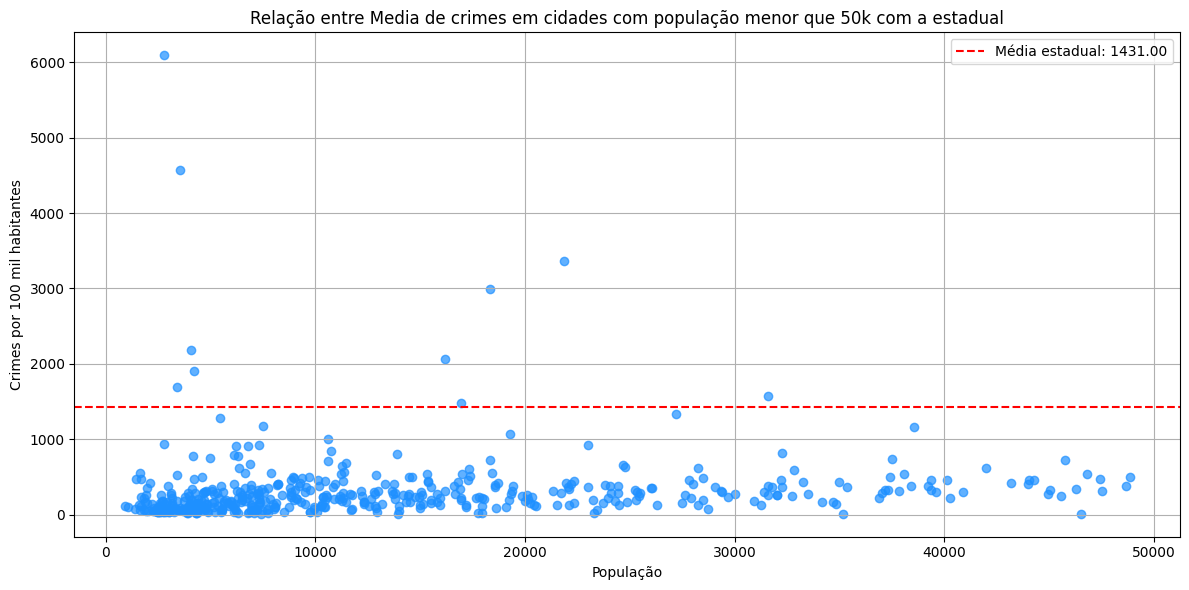

In [ ]:
import matplotlib.pyplot as plt

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(df_cidades_filtrado["QUANTIDADE_POPULACAO"], df_cidades_filtrado["CRIMES_POR_100K"], color='dodgerblue', alpha=0.7)

# Linha horizontal com a média
plt.axhline(y=media_estadual, color='red', linestyle='--', label=f'Média estadual: {media_estadual:.2f}')

# Labels e título
plt.xlabel("População")
plt.ylabel("Crimes por 100 mil habitantes")
plt.title("Relação entre Media de crimes em cidades com população menor que 50k com a estadual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_cidades_filtrado.loc[df_cidades_filtrado.CRIMES_POR_100K > 1431]

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K
71,Araçariguama,735,21856,3363.0
93,Miracatu,548,18330,2990.0
103,Guararema,497,31576,1574.0
119,São Lourenço da Serra,335,16185,2070.0
136,Juquiá,252,16954,1486.0
163,São Pedro,169,2774,6092.0
164,Itararé,162,3549,4565.0
219,Glicério,89,4084,2179.0
235,Corumbataí,80,4206,1902.0
269,Pongaí,57,3381,1686.0
